<a href="https://colab.research.google.com/github/Siyu-Miao/AI-project/blob/main/Copy_of_AI_Project(RNN)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # !pip install torch
# !pip install --upgrade pandas
# !pip install --upgrade --no-cache-dir pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

base_path = '/content/drive/My Drive/urban_AI_updated/'

cityD_df = pd.read_csv(base_path + 'cityD-dataset.csv')

每 10 个连续坐标点预测第 11 个点的位置（归一化的 x, y 坐标）；

输出模型训练输入 X 和预测目标 y。



In [ ]:

unique_users = cityD_df['uid'].nunique()

# 按用户分组，统计每个用户的移动轨迹长度（天数 * 时间点数）
trajectory_lengths = cityD_df.groupby('uid').size().describe()


missing_values = cityD_df.isnull().sum()

unique_users, trajectory_lengths, missing_values


(6000,
 count    6000.000000
 mean     1403.022500
 std       548.569411
 min       200.000000
 25%      1042.750000
 50%      1362.000000
 75%      1751.000000
 max      3435.000000
 dtype: float64,
 uid    0
 d      0
 t      0
 x      0
 y      0
 dtype: int64)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
import random

# ----------------------------
# Step 1: Select active users
# ----------------------------
top_active_uids = cityD_df['uid'].value_counts().index
active_users_sample = cityD_df[cityD_df['uid'].isin(top_active_uids)].copy()

# Sort
active_users_sample = active_users_sample.sort_values(by=['uid', 'd', 't'])

# ----------------------------
# Step 2: Train/Val Split by Day
# ----------------------------
train_df = active_users_sample[active_users_sample['d'] <= 59].copy()
val_df   = active_users_sample[active_users_sample['d'] >= 60].copy()

# Normalize using global range
for df_ in [train_df, val_df]:
    df_['xy'] = list(zip(df_['x'], df_['y']))

# ----------------------------
# Step 3: Create sequences
# ----------------------------
def build_sequences(data, seq_len=10):
    X, y = [], []
    for uid, group in data.groupby('uid'):
        group = group.sort_values(by=['d', 't'])
        coords = list(group['xy'])
        for i in range(len(coords) - seq_len):
            X.append(coords[i:i+seq_len])
            y.append(coords[i+seq_len])
    return np.array(X), np.array(y)

X_train, y_train = build_sequences(train_df)
X_test, y_test   = build_sequences(val_df)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)





In [ ]:
# ================================
# Add DataLoader for batch training
# ================================
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512  # 或者根据你的内存大小调整，比如32、128都行

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ----------------------------
# Step 4: RNN Model Definition
# ----------------------------
class SimpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  # last step output

# Instantiate model
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10  # 看你想跑几轮

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}')

# ================================
# Evaluate on test set
# ================================
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
print(f'Test Loss: {test_loss/len(test_loader):.4f}')




Epoch 1, Train Loss: 1100.3441
Epoch 2, Train Loss: 55.4730
Epoch 3, Train Loss: 54.7756
Epoch 4, Train Loss: 54.6520
Epoch 5, Train Loss: 54.4664
Epoch 6, Train Loss: 54.3894
Epoch 7, Train Loss: 54.3164
Epoch 8, Train Loss: 54.3146
Epoch 9, Train Loss: 54.2911
Epoch 10, Train Loss: 54.1999
Test Loss: 55.3012


In [ ]:
# # ---------------------------
# # Step 6: Evaluation
# # ---------------------------

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model.to(DEVICE) # This line is added to move the model to the same device as the input tensor

model.eval()
X_test_tensor = X_test_tensor.to(DEVICE)

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().cpu().numpy()  # ⚡关键是detach+cpu
    y_true = y_test  # 真实标签仍是 numpy

# 计算指标
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("\n✅ Evaluation Metrics:")
print(f" MSE  = {mse:.5f}")
print(f" RMSE = {rmse:.5f}")
print(f" MAE  = {mae:.5f}")


✅ Evaluation Metrics:
 MSE  = 55.08264
 RMSE = 7.42177
 MAE  = 3.74060


<ipython-input-9-8ca6224da54a>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 100)  # 调色盘，最多100种不同颜色


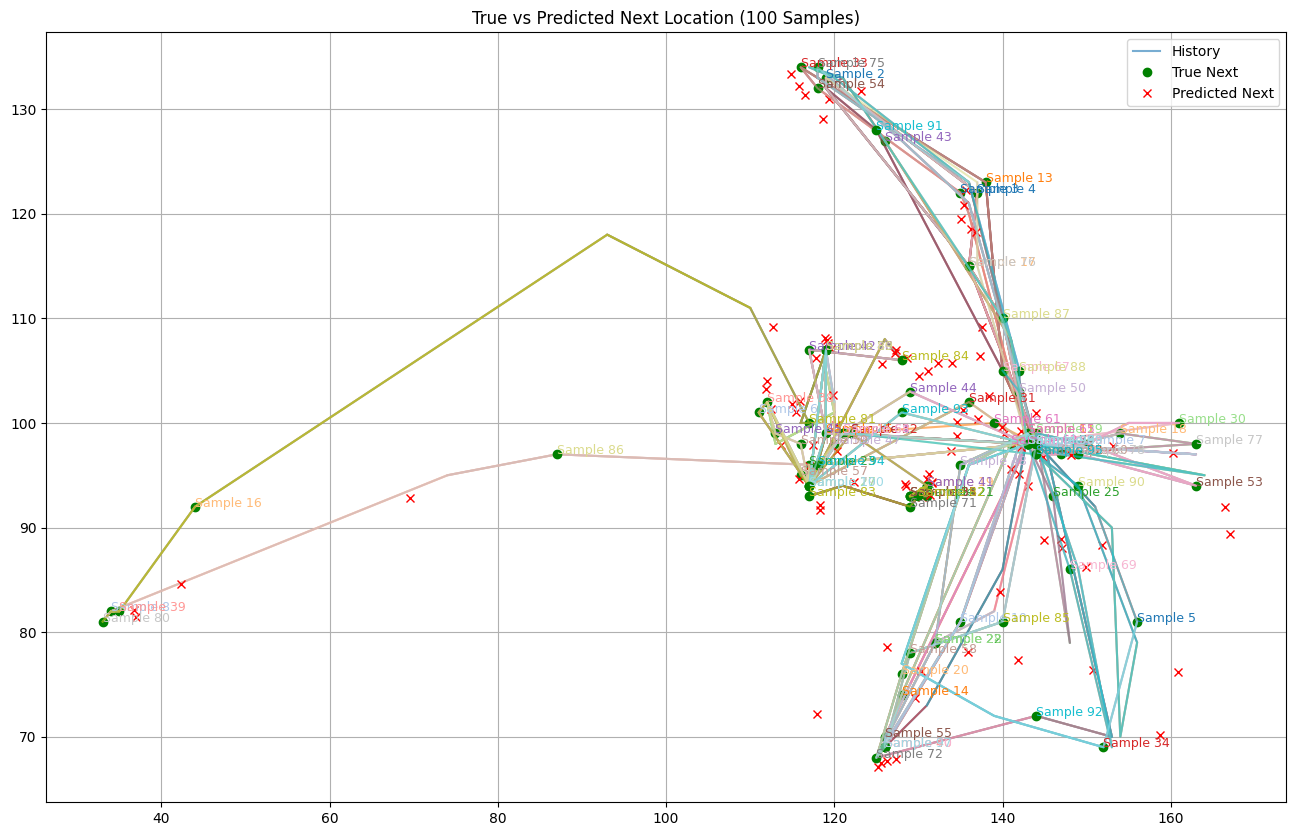

In [ ]:
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm  # 用colormap来自动生成不同颜色

# ---------------------------
# Step 7: Visualization (Colorful Lines + Labels)
# ---------------------------

sample_size = min(200, len(y_test))
sampled_idx = random.sample(range(sample_size), 100)

colors = cm.get_cmap('tab20', 100)  # 调色盘，最多100种不同颜色

plt.figure(figsize=(16, 10))

for i, idx in enumerate(sampled_idx):
    history = X_test[idx]
    true_next = y_test[idx]
    pred_next = y_pred[idx]

    color = colors(i)  # 不同轨迹用不同颜色

    # 画轨迹历史（彩色线）
    plt.plot(*zip(*history), color=color, alpha=0.6)

    # 画真实下一个点（绿色圆圈）
    plt.plot(*true_next, 'go')

    # 画预测下一个点（红色叉）
    plt.plot(*pred_next, 'rx')

    # 加编号注释
    plt.text(true_next[0], true_next[1], f"Sample {i+1}", color=color, fontsize=9)

plt.title("True vs Predicted Next Location (100 Samples)")
plt.legend(["History", "True Next", "Predicted Next"])
plt.grid(True)
plt.show()


In [ ]:
# batch_size = 1000

# for batch_start in range(0, len(X_test), batch_size):
#     batch_end = min(batch_start + batch_size, len(X_test))
#     plt.figure(figsize=(16, 10))
#     for idx in range(batch_start, batch_end):
#         history = X_test[idx]
#         plt.plot(*zip(*history), color='gray', alpha=0.1, linewidth=0.5)
#     plt.title(f"Trajectories from {batch_start} to {batch_end}")
#     plt.grid(True)
#     plt.show()


In [ ]:
from google.colab import files
import torch

# Save out your state_dict
torch.save(model.state_dict(), 'RNN-model.pth')

# This will pop up a browser download dialog
files.download('RNN-model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>